**Fixed:** For P-ONE you should NOT use the South Pole shortcut. Use detector latitude + (zenith, azimuth) to compute sinδ.


# 0) Information

## 0.1) Opening angle (angular error) — definition

In neutrino-direction reconstruction we compare the **true** neutrino direction with the **reconstructed / predicted** direction.  
The **opening angle** (often denoted $\Delta\psi$) is the **3D angular separation** between these two directions on the unit sphere.

### Vector definition
Let $\mathbf{u}_{\mathrm{true}}$ and $\mathbf{u}_{\mathrm{pred}}$ be **unit vectors** pointing along the true and reconstructed directions. Then

$$
\Delta\psi \equiv \arccos\!\left(\mathbf{u}_{\mathrm{true}}\cdot \mathbf{u}_{\mathrm{pred}}\right),
\qquad 0 \le \Delta\psi \le \pi .
$$

This is the angle of the smallest rotation that takes the true direction into the predicted one.

### Definition in terms of zenith / azimuth
Using zenith $\theta$ and azimuth $\phi$ (both in radians), the unit vector is

$$
\mathbf{u}(\theta,\phi) =
\left(\sin\theta\cos\phi,\ \sin\theta\sin\phi,\ \cos\theta\right).
$$

So the opening angle can be computed via the spherical law of cosines:

$$
\cos(\Delta\psi)=
\sin\theta_{\mathrm{true}}\sin\theta_{\mathrm{pred}}\cos(\phi_{\mathrm{true}}-\phi_{\mathrm{pred}})
+\cos\theta_{\mathrm{true}}\cos\theta_{\mathrm{pred}}.
$$

### Notes
- $\Delta\psi$ is **coordinate-invariant** (a true 3D separation; not separate errors in $\theta$ and $\phi$).
- In performance plots we often show the **median** $\Delta\psi$ or a containment (e.g. 68% quantile) versus energy.


# 0) P-ONE νμ CC sample (μ + hadrons) — Reconstruction Performance Plots (TDR-inspired)

**Note:** Although this sample is often described as “Mu± + hadrons”, the `I3MCTree_postprop` shows a **primary `NuMu`** and an interaction vertex producing **`MuMinus/MuPlus` + hadronic cascade**. So treat it as a **neutrino-induced muon** sample when matching IceCube-Gen2 TDR figures.

- **Angular resolution** vs energy (overall + split by declination bands)
- **Energy resolution** vs energy (68% containment style)

⚠️ **Important limitation (dataset):** this is **muon-only MC** (Mu± + hadrons), not neutrino MC.
So the **neutrino effective area** plots like IceCube-Gen2 **TDR Figure 42** (**A_eff vs Eν**) cannot be reproduced *directly* from this dataset alone.

**TDR mapping (for reference):**
- Angular resolution (tracks): analogous to **TDR Fig. 43 (Right)**  
- Energy resolution: analogous to **TDR Table 7** (we turn it into a curve vs energy)




# 1) Imports 


In [1]:


from __future__ import annotations

from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("once")

# Global plotting defaults (clean, paper-ish)
plt.rcParams.update({
    "figure.figsize": (7.2, 4.8),
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 10,
})



# 2) Configuration

In [2]:


BASE = Path.cwd().resolve().parent

# Where to save plots + tables
OUTDIR = (Path.cwd() / "plots_performance").resolve()
OUTDIR.mkdir(parents=True, exist_ok=True)

# File patterns (GraphNeT)
ENERGY_GLOB  = "energy/test_predictions*.csv"
AZIMUTH_GLOB = "azimuth/test_predictions*.csv"
ZENITH_GLOB  = "zenith/test_predictions*.csv"

# Energy binning in log10(E/GeV)
LOGE_BIN_WIDTH = 0.25
MIN_EVENTS_PER_BIN = 50   # skip bins with too few stats

# TDR-like declination bands shown in IceCube-Gen2 Fig. 42 (Left) legend
# We'll use the same bins for the angular-resolution split plot.
SIN_DELTA_BANDS = [
    ( 0.6,  1.0),
    ( 0.2,  0.6),
    (-0.2,  0.2),
    (-0.6, -0.2),
    (-1.0, -0.6),
]





# =======================
# Detector location for declination (δ)
# =======================
# IceCube South Pole shortcut sinδ ≈ -cos(zenith) is ONLY valid at the Pole.
# For P-ONE (not at the Pole), declination depends on BOTH zenith and azimuth AND the detector latitude.
#
# Set this to the geographic latitude of the P-ONE site (degrees, +North).
DETECTOR_LAT_DEG = 47.77  # <-- update if you have a more precise site latitude

# IceTray/I3Direction convention: azimuth=0 points to local +x, and in IceCube coords +x is SOUTH, +y is EAST.
# P-ONE simulation typically follows the same convention; if yours differs, adjust the helper below.
AZIMUTH_ZERO_IS_SOUTH = True
# Energy axis label used in plots (set to match what `true_energy` represents)
# Examples:
#   r"True neutrino energy $E_\nu$ [GeV]"
#   r"True muon energy $E_\mu$ [GeV]"
E_AXIS_LABEL = r"True energy $E$ [GeV]"

print("BASE  :", BASE)
print("OUTDIR:", OUTDIR)


BASE  : /project/6061446/kbas/Graphnet-Applications/Training/EventPulseSeries_nonoise/initiative2
OUTDIR: /project/6061446/kbas/Graphnet-Applications/Training/EventPulseSeries_nonoise/initiative2/analysis/plots_performance


# 3) Load prediction tables

We load the three heads (energy / azimuth / zenith).  
If you have **multiple** `test_predictions*.csv` files per folder, this picks the first (sorted). Edit if needed.


In [3]:

def _find_one(base: Path, pattern: str) -> Path:
    hits = sorted((base).glob(pattern))
    if len(hits) == 0:
        raise FileNotFoundError(f"No files matched: {base / pattern}")
    return hits[0]

energy_path  = _find_one(BASE, ENERGY_GLOB)
azimuth_path = _find_one(BASE, AZIMUTH_GLOB)
zenith_path  = _find_one(BASE, ZENITH_GLOB)

energy_df = pd.read_csv(energy_path)
az_df     = pd.read_csv(azimuth_path)
zen_df    = pd.read_csv(zenith_path)

print("ENERGY :", energy_path,  energy_df.shape)
print("AZIMUTH:", azimuth_path, az_df.shape)
print("ZENITH :", zenith_path,  zen_df.shape)



ENERGY : /project/6061446/kbas/Graphnet-Applications/Training/EventPulseSeries_nonoise/initiative2/energy/test_predictions.csv (41311, 7)
AZIMUTH: /project/6061446/kbas/Graphnet-Applications/Training/EventPulseSeries_nonoise/initiative2/azimuth/test_predictions.csv (41311, 11)
ZENITH : /project/6061446/kbas/Graphnet-Applications/Training/EventPulseSeries_nonoise/initiative2/zenith/test_predictions.csv (41311, 8)


In [4]:
display(energy_df.head(2))



,true_energy,pred_energy,pred_log10_energy,true_log10_energy,residual_log10,residual,event_id
0,108859.773438,1304.831177,3.115554,5.036868,-1.921313,-107554.945312,242
1,14684.890625,26424.460938,4.422006,4.166871,0.255136,11739.570312,778


In [5]:
display(az_df.head(2))


,true_azimuth_radian,pred_azimuth_radian,true_azimuth_degree,pred_azimuth_degree,true_azimuth_degree_signed,pred_azimuth_degree_signed,pred_azimuth_degree_adj,kappa,event_id,residual_azimuth_radian,residual_azimuth_degree
0,4.139313,3.670218,237.165146,210.288010,-122.834846,-149.711990,210.288010,1.444075,242,-0.469095,-26.877136
1,5.674534,5.704504,325.126831,326.844025,-34.873158,-33.155994,326.844025,91.555046,778,0.029971,1.717192


In [6]:
display(zen_df.head(2))

,true_zenith_radian,pred_zenith_radian,true_zenith_degree,pred_zenith_degree,kappa,event_id,residual_zenith_radian,residual_zenith_degree
0,0.390769,0.897717,22.389387,51.435383,12.699632,242,0.506948,29.045994
1,1.441897,1.430777,82.614624,81.977478,102.253052,778,-0.011120,-0.637147


# 4) Merge energy + azimuth + zenith into a single table

We merge on a common event identifier if it exists (`event_id` is most common).  
If no merge key exists, we fall back to row-order concatenation (not recommended).


In [7]:


def _choose_merge_key(*dfs: pd.DataFrame) -> str | None:
    # keys we try, in order
    candidates = ["event_id", "event_no", "event", "idx", "index"]
    common = set(dfs[0].columns)
    for d in dfs[1:]:
        common &= set(d.columns)
    for k in candidates:
        if k in common:
            return k
    return None

merge_key = _choose_merge_key(energy_df, az_df, zen_df)
print("Chosen merge key:", merge_key)

# Suffix all columns from azimuth/zenith (except merge key) to avoid collisions
az_df2  = az_df.copy()
zen_df2 = zen_df.copy()

if merge_key is not None:
    az_df2.columns  = [c if c == merge_key else f"{c}_AZ"  for c in az_df2.columns]
    zen_df2.columns = [c if c == merge_key else f"{c}_ZEN" for c in zen_df2.columns]

    df = energy_df.merge(az_df2, on=merge_key, how="inner")
    df = df.merge(zen_df2, on=merge_key, how="inner")
else:
    # Fallback: assume identical row order
    df = pd.concat(
        [energy_df, az_df.add_suffix("_AZ"), zen_df.add_suffix("_ZEN")],
        axis=1,
    )

print("Merged df:", df.shape)
display(df.head(3))

# Basic sanity checks
if merge_key is not None:
    dup = df[merge_key].duplicated().sum()
    if dup > 0:
        print(f"WARNING: {dup} duplicated {merge_key} values after merge.")


Chosen merge key: event_id
Merged df: (41311, 24)


,true_energy,pred_energy,pred_log10_energy,true_log10_energy,residual_log10,residual,event_id,true_azimuth_radian_AZ,pred_azimuth_radian_AZ,true_azimuth_degree_AZ,...,kappa_AZ,residual_azimuth_radian_AZ,residual_azimuth_degree_AZ,true_zenith_radian_ZEN,pred_zenith_radian_ZEN,true_zenith_degree_ZEN,pred_zenith_degree_ZEN,kappa_ZEN,residual_zenith_radian_ZEN,residual_zenith_degree_ZEN
0,108859.773438,1304.831177,3.115554,5.036868,-1.921313,-107554.945312,242,4.139313,3.670218,237.165146,...,1.444075,-0.469095,-26.877136,0.390769,0.897717,22.389387,51.435383,12.699632,0.506948,29.045994
1,14684.890625,26424.460938,4.422006,4.166871,0.255136,11739.570312,778,5.674534,5.704504,325.126831,...,91.555046,0.029971,1.717192,1.441897,1.430777,82.614624,81.977478,102.253052,-0.011120,-0.637147
2,127.363152,229.665329,2.361095,2.105044,0.256052,102.302177,1171,1.370334,1.463580,78.514381,...,87.435936,0.093246,5.342587,1.758793,1.693512,100.771446,97.031097,95.955757,-0.065281,-3.740348


# 5) Derived quantities (angles, energy, sinδ, opening angle)

We compute:
- `E_true_GeV`, `E_pred_GeV`
- `true_zenith_rad`, `pred_zenith_rad`, `true_azimuth_rad`, `pred_azimuth_rad`
- - `sin_delta` computed from (**detector latitude + zenith + azimuth**) for P-ONE (equatorial declination proxy)
- `opening_angle_deg` (Δψ)


In [8]:
# =======================
#  Helpers
# =======================

def _first_existing(df: pd.DataFrame, candidates: list[str]) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of these columns exist: {candidates}")

def _to_radians(arr: np.ndarray) -> np.ndarray:
    # Heuristic: if values look like degrees, convert.
    # zenith: [0, π] rad vs [0, 180] deg
    # azimuth: [0, 2π] rad vs [0, 360] deg
    m = np.nanmax(arr)
    if m > 2*np.pi + 0.2:
        return np.deg2rad(arr)
    return arr

def _wrap_0_2pi(phi: np.ndarray) -> np.ndarray:
    return np.mod(phi, 2*np.pi)



def compute_sin_delta_from_local(th: np.ndarray, ph: np.ndarray, lat_deg: float, azimuth_zero_is_south: bool = True) -> np.ndarray:
    """
    Compute sin(declination) from LOCAL (zenith, azimuth) and detector latitude.

    This avoids the IceCube South Pole shortcut sinδ ≈ -cos(zenith), which is only valid at the Pole.

    Parameters
    ----------
    th : array
        Zenith angle in radians (0=up, π=down).
    ph : array
        Azimuth angle in radians.
        If `azimuth_zero_is_south=True`, we assume IceTray/I3Direction convention where:
            azimuth=0 -> South, azimuth=π/2 -> East.
        If your convention is azimuth=0 -> North (astronomy convention), set this to False.
    lat_deg : float
        Detector geographic latitude in degrees (+North).
    azimuth_zero_is_south : bool
        Whether azimuth is measured from South (IceTray) or North (astronomy).

    Returns
    -------
    sin_delta : array
        sin(δ) values in [-1,1].
    """
    lat = np.deg2rad(lat_deg)

    # altitude a = π/2 - zenith
    # sin a = cos(th), cos a = sin(th)
    sin_a = np.cos(th)
    cos_a = np.sin(th)

    # Convert azimuth to "from North" if needed (astronomy convention)
    # If azimuth is from South: A_north = az_south + π
    if azimuth_zero_is_south:
        A = ph + np.pi
    else:
        A = ph

    # Standard horizontal->equatorial relation:
    # sin δ = sin φ * sin a + cos φ * cos a * cos A
    sin_delta = np.sin(lat) * sin_a + np.cos(lat) * cos_a * np.cos(A)
    return np.clip(sin_delta, -1.0, 1.0)

def compute_opening_angle_deg(th_true, ph_true, th_pred, ph_pred) -> np.ndarray:
    # u = (sinθ cosφ, sinθ sinφ, cosθ)
    ux_t = np.sin(th_true) * np.cos(ph_true)
    uy_t = np.sin(th_true) * np.sin(ph_true)
    uz_t = np.cos(th_true)

    ux_p = np.sin(th_pred) * np.cos(ph_pred)
    uy_p = np.sin(th_pred) * np.sin(ph_pred)
    uz_p = np.cos(th_pred)

    dot = ux_t*ux_p + uy_t*uy_p + uz_t*uz_p
    dot = np.clip(dot, -1.0, 1.0)
    return np.degrees(np.arccos(dot))

def build_logE_bins(logE: pd.Series, width: float) -> np.ndarray:
    xmin = np.floor(np.nanmin(logE) / width) * width
    xmax = np.ceil(np.nanmax(logE) / width) * width
    return np.arange(xmin, xmax + width, width)

def binned_quantiles(values: pd.Series, bins: pd.Categorical, qs=(0.16, 0.50, 0.84)) -> pd.DataFrame:
    g = values.groupby(bins, observed=True)
    out = g.quantile(list(qs)).unstack()
    out.columns = [f"q{int(q*100):02d}" for q in qs]
    out["n"] = g.size()
    out["logE_center"] = [iv.mid for iv in out.index]
    return out.reset_index(drop=True)



In [9]:
# =======================
#  Resolve columns + compute derived columns
# =======================

# ---- Energy truth/pred ----
# Prefer linear energy columns if they exist, else reconstruct from log10 columns.
TRUE_E_COL_CANDIDATES = ["true_energy", "energy_true", "E_true", "true_E"]
PRED_E_COL_CANDIDATES = ["pred_energy", "energy_pred", "E_pred", "pred_E"]

TRUE_LOGE_COL_CANDIDATES = ["true_log10_energy", "log10_true_energy", "true_logE"]
PRED_LOGE_COL_CANDIDATES = ["pred_log10_energy", "log10_pred_energy", "pred_logE"]

if any(c in df.columns for c in TRUE_E_COL_CANDIDATES):
    true_E_col = _first_existing(df, TRUE_E_COL_CANDIDATES)
    E_true_GeV = df[true_E_col].to_numpy(dtype=float)
elif any(c in df.columns for c in TRUE_LOGE_COL_CANDIDATES):
    true_logE_col = _first_existing(df, TRUE_LOGE_COL_CANDIDATES)
    E_true_GeV = 10 ** df[true_logE_col].to_numpy(dtype=float)
else:
    raise KeyError("Could not find true energy column (linear or log10).")

if any(c in df.columns for c in PRED_E_COL_CANDIDATES):
    pred_E_col = _first_existing(df, PRED_E_COL_CANDIDATES)
    E_pred_GeV = df[pred_E_col].to_numpy(dtype=float)
elif any(c in df.columns for c in PRED_LOGE_COL_CANDIDATES):
    pred_logE_col = _first_existing(df, PRED_LOGE_COL_CANDIDATES)
    E_pred_GeV = 10 ** df[pred_logE_col].to_numpy(dtype=float)
else:
    raise KeyError("Could not find predicted energy column (linear or log10).")

df["E_true_GeV"] = E_true_GeV
df["E_pred_GeV"] = E_pred_GeV
df["logE_true"] = np.log10(df["E_true_GeV"].clip(lower=1e-9))

# ---- Angles ----
# The current notebook uses these (GraphNeT-style):
# true_zenith_radian_ZEN, pred_zenith_radian_ZEN, true_azimuth_radian_AZ, pred_azimuth_radian_AZ
TRUE_TH_CANDS = ["true_zenith_radian_ZEN", "true_zenith_radian", "true_zenith_ZEN", "true_zenith"]
PRED_TH_CANDS = ["pred_zenith_radian_ZEN", "pred_zenith_radian", "pred_zenith_ZEN", "pred_zenith"]

TRUE_PH_CANDS = ["true_azimuth_radian_AZ", "true_azimuth_radian", "true_azimuth_AZ", "true_azimuth"]
PRED_PH_CANDS = ["pred_azimuth_radian_AZ", "pred_azimuth_radian", "pred_azimuth_AZ", "pred_azimuth"]

true_th = df[_first_existing(df, TRUE_TH_CANDS)].to_numpy(dtype=float)
pred_th = df[_first_existing(df, PRED_TH_CANDS)].to_numpy(dtype=float)
true_ph = df[_first_existing(df, TRUE_PH_CANDS)].to_numpy(dtype=float)
pred_ph = df[_first_existing(df, PRED_PH_CANDS)].to_numpy(dtype=float)

true_th = _to_radians(true_th)
pred_th = _to_radians(pred_th)
true_ph = _wrap_0_2pi(_to_radians(true_ph))
pred_ph = _wrap_0_2pi(_to_radians(pred_ph))

df["true_zenith_rad"]  = true_th
df["pred_zenith_rad"]  = pred_th
df["true_azimuth_rad"] = true_ph
df["pred_azimuth_rad"] = pred_ph

# South Pole approximation: sinδ ≈ -cos(zenith)
df["sin_delta"] = compute_sin_delta_from_local(
    df["true_zenith_rad"].to_numpy(),
    df["true_azimuth_rad"].to_numpy(),
    lat_deg=DETECTOR_LAT_DEG,
    azimuth_zero_is_south=AZIMUTH_ZERO_IS_SOUTH,
)
# Opening angle Δψ
df["opening_angle_deg"] = compute_opening_angle_deg(
    df["true_zenith_rad"].to_numpy(),
    df["true_azimuth_rad"].to_numpy(),
    df["pred_zenith_rad"].to_numpy(),
    df["pred_azimuth_rad"].to_numpy(),
)

print("opening_angle_deg summary:")
display(df["opening_angle_deg"].describe(percentiles=[0.5, 0.68, 0.9, 0.95, 0.99]))


opening_angle_deg summary:


count    41311.000000
mean         9.342585
std         16.451351
min          0.013139
50%          3.717945
68%          6.559512
90%         22.760465
95%         38.141500
99%         89.537007
max        178.434996
Name: opening_angle_deg, dtype: float64

# 6) Plot — Angular resolution (overall): median Δψ vs energy


- **x-axis:** True energy ($E$) \[GeV\] *(log scale)*
- **y-axis:** Median opening angle ($\Psi_{\rm med}$) \[deg\]
- **Shaded band:** 16–84% (≈ 68% containment)

**TDR analogue:** Fig. 43 (Right) *(track angular resolution)*.


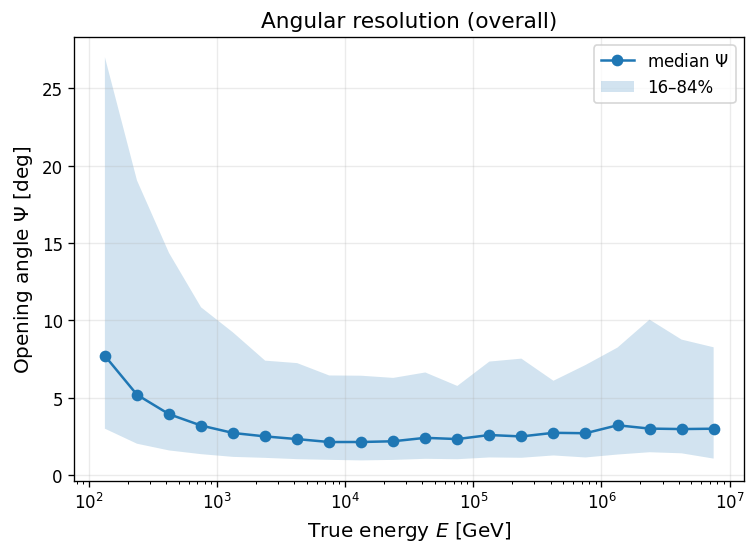

Saved: /project/6061446/kbas/Graphnet-Applications/Training/EventPulseSeries_nonoise/initiative2/analysis/plots_performance/angular_resolution_overall.png


In [10]:

bins = build_logE_bins(df["logE_true"], LOGE_BIN_WIDTH)
df["logE_bin"] = pd.cut(df["logE_true"], bins=bins, include_lowest=True)

q = binned_quantiles(df["opening_angle_deg"], df["logE_bin"], qs=(0.16, 0.50, 0.84))
q = q[q["n"] >= MIN_EVENTS_PER_BIN].copy()

E_centers = 10 ** q["logE_center"].to_numpy()

fig, ax = plt.subplots()
ax.plot(E_centers, q["q50"], marker="o", linestyle="-", label=r"median $\Psi$")
ax.fill_between(E_centers, q["q16"], q["q84"], alpha=0.2, label="16–84%")

ax.set_xscale("log")
ax.set_xlabel(E_AXIS_LABEL)
ax.set_ylabel(r"Opening angle $\Psi$ [deg]")
ax.set_title("Angular resolution (overall)")
ax.legend()

out_png = OUTDIR / "angular_resolution_overall.png"
out_pdf = OUTDIR / "angular_resolution_overall.pdf"
fig.savefig(out_png, bbox_inches="tight")
fig.savefig(out_pdf, bbox_inches="tight")
plt.show()

print("Saved:", out_png)


# 7) Plot — Angular resolution split by declination bands (sinδ)



- **x-axis:** True energy ($E$) \[GeV\] *(log scale)*
- **y-axis:** Median opening angle ($\Psi_{\rm med}$) \[deg\]
- **Curves:** TDR-like $\sin\delta$ bands.

**TDR analogue:** again Fig. 43 (Right), but shown per band.


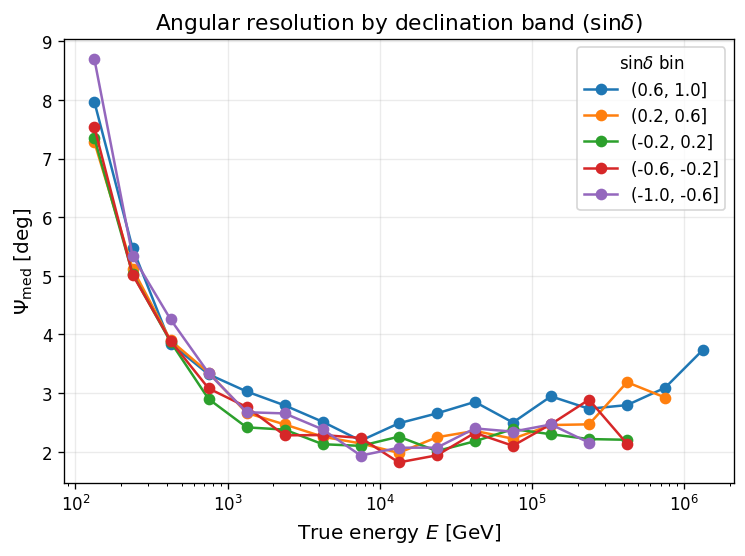

Saved: /project/6061446/kbas/Graphnet-Applications/Training/EventPulseSeries_nonoise/initiative2/analysis/plots_performance/angular_resolution_by_sindelta.png


In [11]:

fig, ax = plt.subplots()

for lo, hi in SIN_DELTA_BANDS:
    sub = df[(df["sin_delta"] > lo) & (df["sin_delta"] <= hi)].copy()
    if len(sub) == 0:
        print(f"Band sinδ in ({lo},{hi}] has 0 events -> skipped.")
        continue

    sub["logE_bin"] = pd.cut(sub["logE_true"], bins=bins, include_lowest=True)
    med = sub.groupby("logE_bin", observed=True)["opening_angle_deg"].median()
    counts = sub.groupby("logE_bin", observed=True)["opening_angle_deg"].size()

    # keep only bins with enough stats
    med = med[counts >= MIN_EVENTS_PER_BIN].dropna()
    if len(med) == 0:
        print(f"Band sinδ in ({lo},{hi}] has no bins with n >= {MIN_EVENTS_PER_BIN}.")
        continue

    logE_center = np.array([iv.mid for iv in med.index])
    E_center = 10 ** logE_center
    ax.plot(E_center, med.values, marker="o", linestyle="-", label=f"({lo}, {hi}]")

ax.set_xscale("log")
ax.set_xlabel(E_AXIS_LABEL)
ax.set_ylabel(r"$\Psi_{\rm med}$ [deg]")
ax.set_title(r"Angular resolution by declination band (sin$\delta$)")
ax.legend(title=r"sin$\delta$ bin")

out_png = OUTDIR / "angular_resolution_by_sindelta.png"
out_pdf = OUTDIR / "angular_resolution_by_sindelta.pdf"
fig.savefig(out_png, bbox_inches="tight")
fig.savefig(out_pdf, bbox_inches="tight")
plt.show()

print("Saved:", out_png)


# 8) Plot — Energy resolution vs energy (68% containment style)



For each energy bin we compute:

- **bias:** median of $\log_{10}\!\left(E_{\rm pred}/E_{\rm true}\right)$  
- **resolution (68%):** half-width of the 16–84% interval of $\log_{10}\!\left(E_{\rm pred}/E_{\rm true}\right)$

This is the closest “curve version” of **TDR Table 7**.

- **x-axis:** True energy ($E$) \[GeV\] *(log scale)*
- **y-axis:** $\sigma_{68}\!\left[\log_{10}\!\left(E_{\rm pred}/E_{\rm true}\right)\right]$


,logE_center,E_center_GeV,n,q16,q50,q84,sigma68_log10,bias_log10,frac68_approx
0,2.1245,133.198704,8472,0.013899,0.149271,0.416291,0.201196,0.149271,0.589264
1,2.3750,237.137371,6497,-0.102922,0.071889,0.346886,0.224904,0.071889,0.678433
2,2.6250,421.696503,5129,-0.196953,0.024710,0.357911,0.277432,0.024710,0.894226
3,2.8750,749.894209,4128,-0.308312,0.005263,0.365972,0.337142,0.005263,1.173410
4,3.1250,1333.521432,3584,-0.425391,-0.013959,0.329603,0.377497,-0.013959,1.385046
5,3.3750,2371.373706,2956,-0.533887,-0.046841,0.286455,0.410171,-0.046841,1.571407
6,3.6250,4216.965034,2463,-0.632543,-0.106319,0.248692,0.440618,-0.106319,1.758148
7,3.8750,7498.942093,1866,-0.717523,-0.139461,0.239797,0.478660,-0.139461,2.010649
8,4.1250,13335.214322,1449,-0.908682,-0.184422,0.235372,0.572027,-0.184422,2.732734
9,4.3750,23713.737057,1148,-0.961317,-0.167963,0.226994,0.594156,-0.167963,2.927856


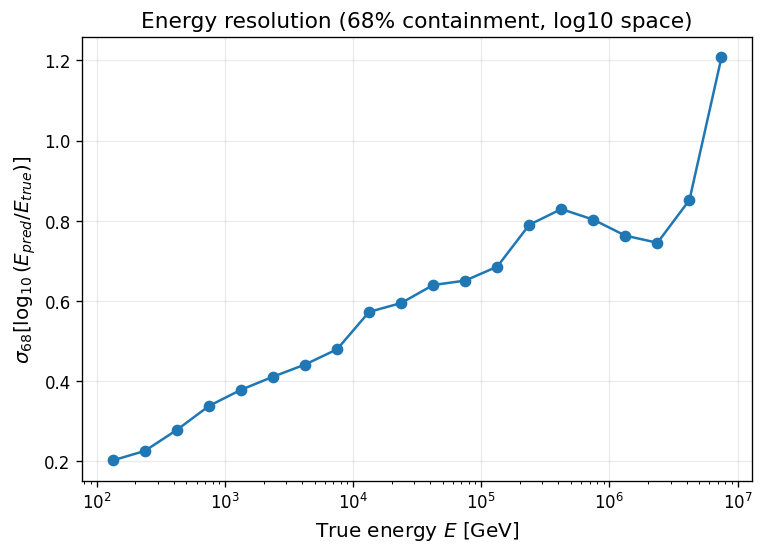

Saved: /project/6061446/kbas/Graphnet-Applications/Training/EventPulseSeries_nonoise/initiative2/analysis/plots_performance/energy_resolution_sigma68_log10.png


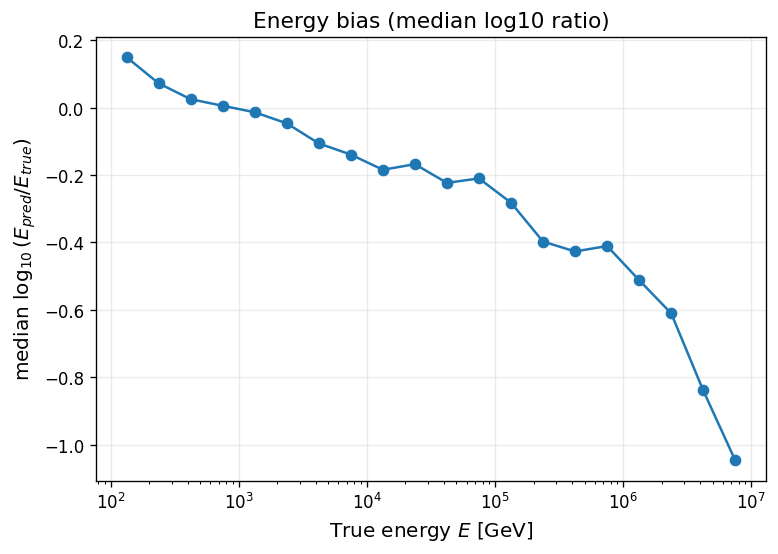

Saved: /project/6061446/kbas/Graphnet-Applications/Training/EventPulseSeries_nonoise/initiative2/analysis/plots_performance/energy_bias_median_log10.png
Saved: /project/6061446/kbas/Graphnet-Applications/Training/EventPulseSeries_nonoise/initiative2/analysis/plots_performance/binned_energy_resolution.csv


In [12]:


ratio = (df["E_pred_GeV"] / df["E_true_GeV"]).to_numpy(dtype=float)
ratio = np.where(np.isfinite(ratio) & (ratio > 0), ratio, np.nan)

df["log10_ratio"] = np.log10(ratio)

# Bin in true logE
df["logE_bin"] = pd.cut(df["logE_true"], bins=bins, include_lowest=True)

g = df["log10_ratio"].groupby(df["logE_bin"], observed=True)
q16 = g.quantile(0.16)
q50 = g.quantile(0.50)
q84 = g.quantile(0.84)
n   = g.size()

summary = pd.DataFrame({
    "logE_center": [iv.mid for iv in q50.index],
    "E_center_GeV": 10 ** np.array([iv.mid for iv in q50.index]),
    "n": n.to_numpy(),
    "q16": q16.to_numpy(),
    "q50": q50.to_numpy(),
    "q84": q84.to_numpy(),
})
summary = summary[summary["n"] >= MIN_EVENTS_PER_BIN].dropna().reset_index(drop=True)

# 68% half-width in log10 space
summary["sigma68_log10"] = 0.5 * (summary["q84"] - summary["q16"])
summary["bias_log10"]    = summary["q50"]

# Optional: convert sigma68_log10 to an approximate fractional resolution
# If sigma is in log10, a multiplicative 1-sigma factor is 10^sigma.
summary["frac68_approx"] = (10 ** summary["sigma68_log10"]) - 1.0

display(summary.head(10))

# ---- Plot: sigma68(log10 ratio) vs energy ----
fig, ax = plt.subplots()
ax.plot(summary["E_center_GeV"], summary["sigma68_log10"], marker="o", linestyle="-")
ax.set_xscale("log")
ax.set_xlabel(E_AXIS_LABEL)
ax.set_ylabel(r"$\sigma_{68}[\log_{10}(E_{pred}/E_{true})]$")
ax.set_title("Energy resolution (68% containment, log10 space)")

out_png = OUTDIR / "energy_resolution_sigma68_log10.png"
out_pdf = OUTDIR / "energy_resolution_sigma68_log10.pdf"
fig.savefig(out_png, bbox_inches="tight")
fig.savefig(out_pdf, bbox_inches="tight")
plt.show()

print("Saved:", out_png)

# ---- Plot: bias vs energy ----
fig, ax = plt.subplots()
ax.plot(summary["E_center_GeV"], summary["bias_log10"], marker="o", linestyle="-")
ax.set_xscale("log")
ax.set_xlabel(E_AXIS_LABEL)
ax.set_ylabel(r"median $\log_{10}(E_{pred}/E_{true})$")
ax.set_title("Energy bias (median log10 ratio)")

out_png2 = OUTDIR / "energy_bias_median_log10.png"
out_pdf2 = OUTDIR / "energy_bias_median_log10.pdf"
fig.savefig(out_png2, bbox_inches="tight")
fig.savefig(out_pdf2, bbox_inches="tight")
plt.show()

print("Saved:", out_png2)

# Save table
out_csv = OUTDIR / "binned_energy_resolution.csv"
summary.to_csv(out_csv, index=False)
print("Saved:", out_csv)


# 9) Effective area (A_eff)

`I3MCTree_postprop` indicates a **primary νμ** → (CC) → **μ + hadrons**, so **A_eff(Eν)** may be possible.

However, to compute **absolute A_eff**, we still need generator metadata such as:
- a per-event generation weight (e.g. `I3MCWeightDict`, `LeptonInjectorWeight`, `OneWeight/TotalWeight`, etc.)
- the thrown phase space (injection area / solid angle / N_generated)

If those weights exist in the I3 frames, we can compute **A_eff vs Eν** (TDR Fig.42-style). If not, we can still compute **resolution plots** (angular/energy), and at best report **selection efficiencies**.

In [13]:
# =======================
# 9) OPTIONAL scaffold: inspect weights in I3 (if you have IceTray locally)
# =======================

# This cell is OPTIONAL.
# It helps us check which weight keys exist in your i3 files.

try:
    from icecube import dataio, icetray, dataclasses, simclasses
except Exception as e:
    print("IceTray not available here -> skipping I3 weight inspection.")
    print("Error:", repr(e))
else:
    # EDIT THIS to point to one example i3 file on your system
    example_i3 = None  # e.g. Path("/path/to/cls_4910.i3")

    if example_i3 is None:
        print("Set `example_i3` to an existing .i3/.i3.gz file to inspect weight keys.")
    else:
        f = dataio.I3File(str(example_i3), "r")
        fr = f.pop_frame()
        print("Frame keys:", list(fr.keys()))

        # Common places to look for weights:
        for k in ["I3MCWeightDict", "EventWeight", "EventWeights", "LeptonInjectorWeight"]:
            if k in fr:
                obj = fr[k]
                print(f"Found {k}: type={type(obj)}")
                try:
                    print(dict(obj))
                except Exception:
                    print(obj)


IceTray not available here -> skipping I3 weight inspection.
Error: ModuleNotFoundError("No module named 'icecube'")


# 10) Output checklist

After running, you should have these files under `plots_performance/`:
- `angular_resolution_overall.(png/pdf)`
- `angular_resolution_by_sindelta.(png/pdf)`
- `energy_resolution_sigma68_log10.(png/pdf)`
- `energy_bias_median_log10.(png/pdf)`
- `binned_energy_resolution.csv`

If a plot looks noisy:
- increase `MIN_EVENTS_PER_BIN`
- increase `LOGE_BIN_WIDTH` (e.g. 0.3)
